In [7]:
!pip install tensorflow 

In [779]:
from numpy.random import seed
seed(101)
import tensorflow
tensorflow.random.set_seed(101)
import pandas as pd
import numpy as np

import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import binary_accuracy

import os
import cv2

import imageio
import skimage
import skimage.io
import skimage.transform

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [780]:

NUM_AUG_IMAGES_WANTED = 1000 


IMAGE_HEIGHT = 96
IMAGE_WIDTH = 96

In [781]:
os.listdir(r'C:\Users\Admin\Downloads\archive')

['ChinaSet_AllFiles', 'Montgomery']

In [782]:
print(len(os.listdir(r"C:\Users\Admin\Downloads\archive\ChinaSet_AllFiles\ChinaSet_AllFiles\CXR_png")))
print(len(os.listdir(r"C:\Users\Admin\Downloads\archive\Montgomery\MontgomerySet\CXR_png")))

663
139


In [783]:
shen_image_list = os.listdir(r"C:\Users\Admin\Downloads\archive\ChinaSet_AllFiles\ChinaSet_AllFiles\CXR_png")
mont_image_list = os.listdir(r"C:\Users\Admin\Downloads\archive\Montgomery\MontgomerySet\CXR_png")

In [784]:
# put the images into dataframes
df_shen = pd.DataFrame(shen_image_list, columns=['image_id'])
df_mont = pd.DataFrame(mont_image_list, columns=['image_id'])

# remove the 'Thunbs.db' line
df_shen = df_shen[df_shen['image_id'] != 'Thumbs.db']
df_mont = df_mont[df_mont['image_id'] != 'Thumbs.db']

# Reset the index or this will cause an error later
df_shen.reset_index(inplace=True, drop=True)
df_mont.reset_index(inplace=True, drop=True)

print(df_shen.shape)
print(df_mont.shape)

(662, 1)
(138, 1)


In [785]:
df_shen.head()

,image_id
0,CHNCXR_0001_0.png
1,CHNCXR_0002_0.png
2,CHNCXR_0003_0.png
3,CHNCXR_0004_0.png
4,CHNCXR_0005_0.png


In [786]:
df_mont.head()

,image_id
0,MCUCXR_0001_0.png
1,MCUCXR_0002_0.png
2,MCUCXR_0003_0.png
3,MCUCXR_0004_0.png
4,MCUCXR_0005_0.png


### Assign labels to the images

In [787]:

def extract_target(x):
    target = int(x[-5])
    if target == 0:
        return 'Normal'
    if target == 1:
        return 'Tuberculosis'

In [788]:
# Assign 

df_shen['target'] = df_shen['image_id'].apply(extract_target)

df_mont['target'] = df_mont['image_id'].apply(extract_target)


### Check the class distribution

In [789]:
# Shenzen Dataset

df_shen['target'].value_counts()

target
Tuberculosis    336
Normal          326
Name: count, dtype: int64

In [790]:
# Montgomery Dataset

df_mont['target'].value_counts()

target
Normal          80
Tuberculosis    58
Name: count, dtype: int64

### Display a ramdom sample of images from each dataset by target

In [791]:

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) 
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) 
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['image_id']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=14)  
    plt.tight_layout()
    plt.show()
    

C:\Users\Admin\AppData\Local\Temp\ipykernel_12820\2262718164.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im=imageio.imread(file)


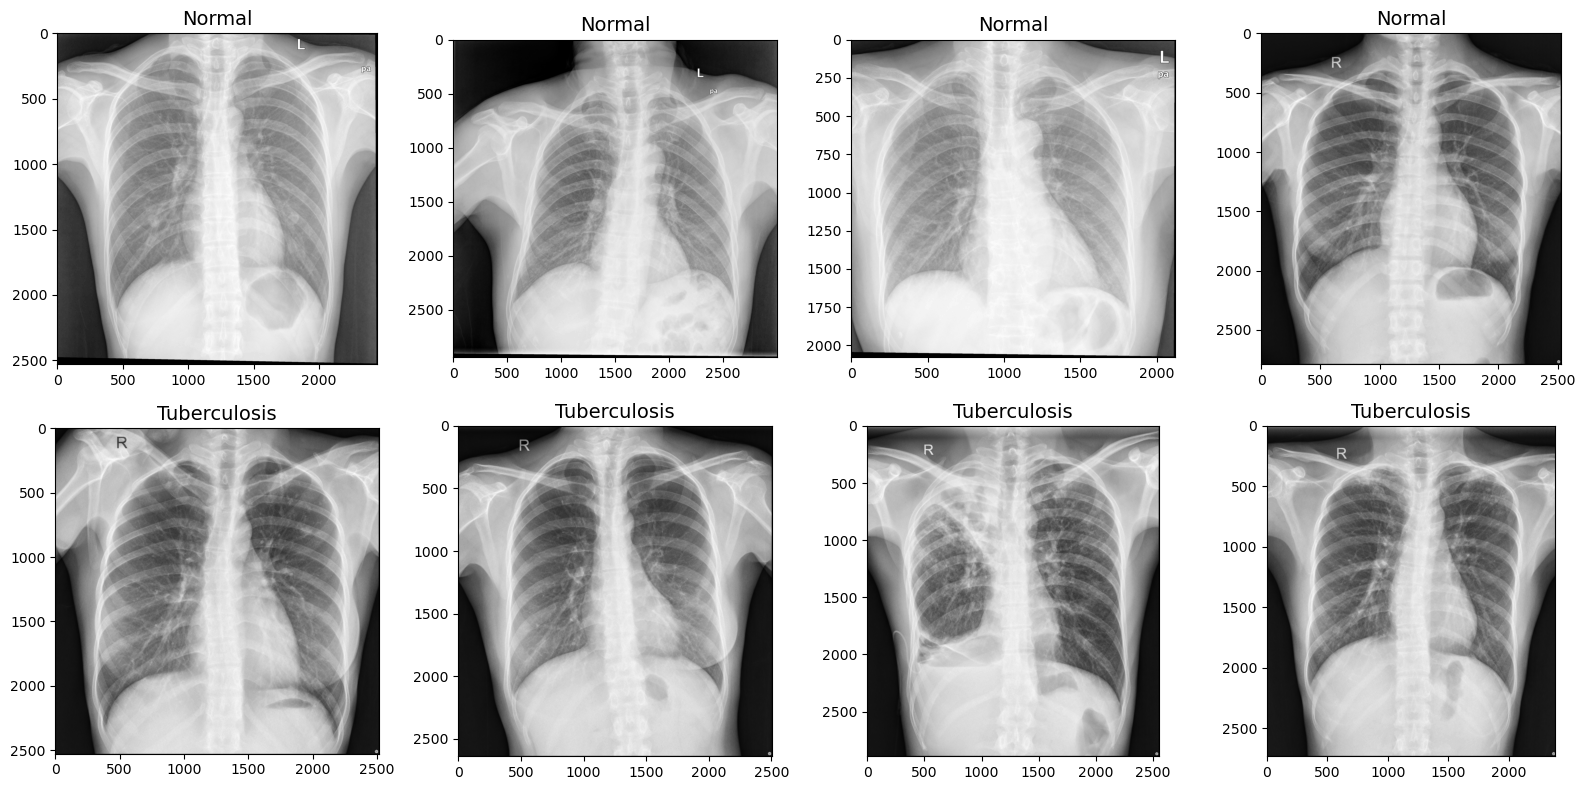

In [792]:
# Shenzen Dataset

IMAGE_PATH = 'C:\\Users\\Admin\\Downloads\\archive\\ChinaSet_AllFiles\\ChinaSet_AllFiles\\CXR_png\\'

draw_category_images('target',4, df_shen, IMAGE_PATH)

C:\Users\Admin\AppData\Local\Temp\ipykernel_12820\2262718164.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im=imageio.imread(file)


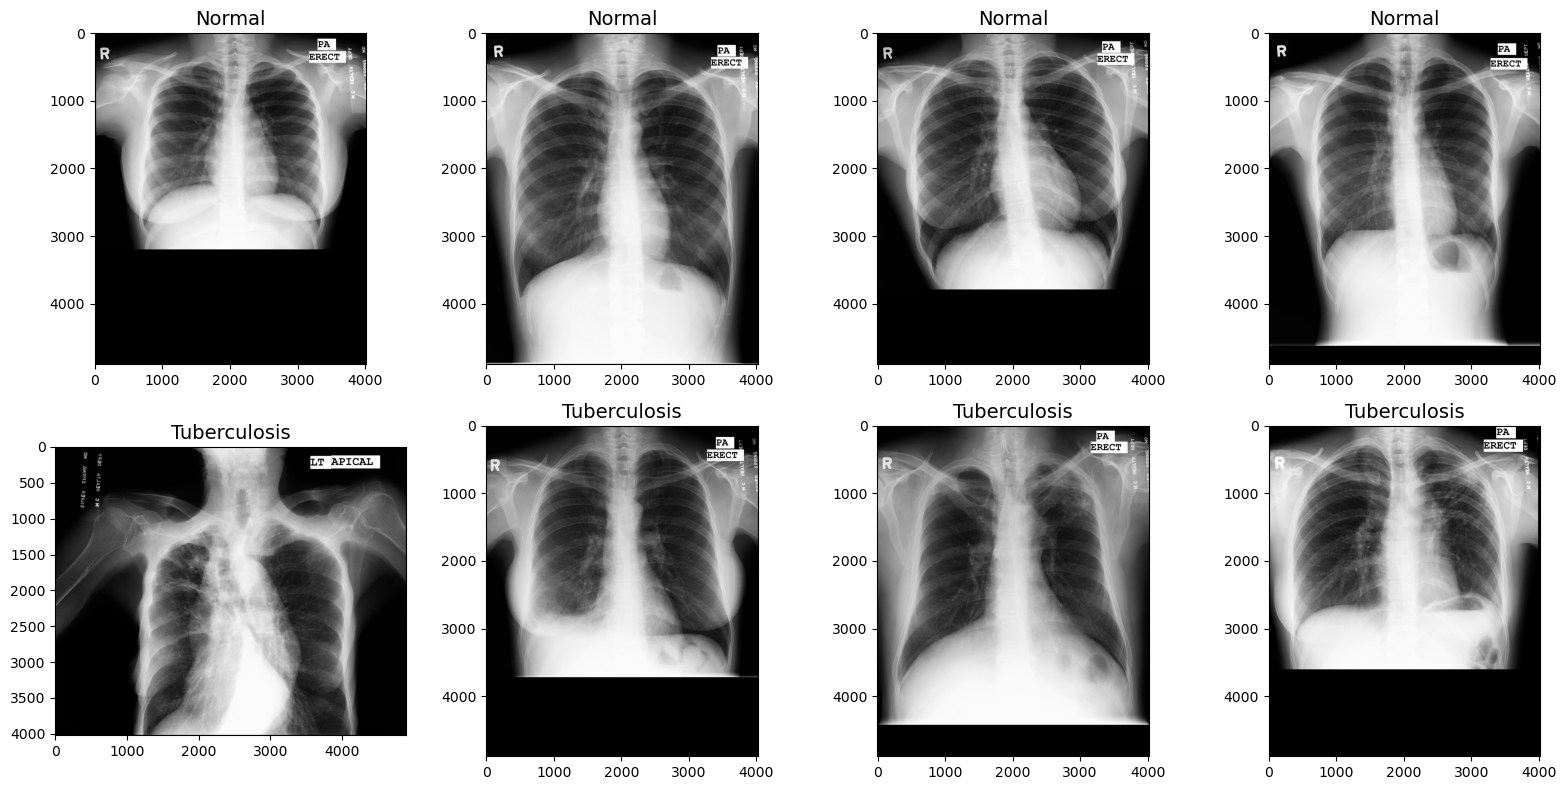

In [793]:
# Montgomery Dataset

IMAGE_PATH = 'C:\\Users\\Admin\\Downloads\\archive\\Montgomery\\MontgomerySet\\CXR_png\\'

draw_category_images('target',4, df_mont, IMAGE_PATH)

### What is the shape of each image and what are its max and min pixel values?
Let's include all this info in the dataframes we created above.

In [794]:
def read_image_sizes(file_name):
    
    image = cv2.imread(IMAGE_PATH + file_name)
    max_pixel_val = image.max()
    min_pixel_val = image.min()
    
    
    if len(image.shape) > 2:
        output = [image.shape[0], image.shape[1], image.shape[2], max_pixel_val, min_pixel_val]
    else:
        output = [image.shape[0], image.shape[1], 1, max_pixel_val, min_pixel_val]
    return output



In [795]:
IMAGE_PATH = "C:\\Users\\Admin\\Downloads\\archive\\ChinaSet_AllFiles\\ChinaSet_AllFiles\\CXR_png\\"

m = np.stack(df_shen['image_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val'])
df_shen = pd.concat([df_shen,df],axis=1, sort=False)

df_shen.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val
0,CHNCXR_0001_0.png,Normal,2919,3000,3,255,0
1,CHNCXR_0002_0.png,Normal,2951,3000,3,255,0
2,CHNCXR_0003_0.png,Normal,2945,2987,3,255,0
3,CHNCXR_0004_0.png,Normal,2933,3000,3,255,0
4,CHNCXR_0005_0.png,Normal,2933,3000,3,255,0


In [796]:
IMAGE_PATH = 'C:\\Users\\Admin\\Downloads\\archive\\Montgomery\\MontgomerySet\\CXR_png\\'

m = np.stack(df_mont['image_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val'])
df_mont = pd.concat([df_mont,df],axis=1, sort=False)

df_mont.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val
0,MCUCXR_0001_0.png,Normal,4020,4892,3,255,0
1,MCUCXR_0002_0.png,Normal,4020,4892,3,255,0
2,MCUCXR_0003_0.png,Normal,4892,4020,3,255,0
3,MCUCXR_0004_0.png,Normal,4892,4020,3,255,0
4,MCUCXR_0005_0.png,Normal,4892,4020,3,255,0


###  channels 

In [797]:
df_shen['c'].value_counts()

c
3    662
Name: count, dtype: int64

In [798]:
df_mont['c'].value_counts()

c
3    138
Name: count, dtype: int64

We see that all images have 3 channels.

###  Train and Val Sets

In [799]:
df_mont['target'].value_counts()

target
Normal          80
Tuberculosis    58
Name: count, dtype: int64

In [800]:

df_data = pd.concat([df_shen, df_mont], axis=0).reset_index(drop=True)

df_data = shuffle(df_data)


df_data.shape

(800, 7)

In [801]:
# Create a new column called 'labels' that maps the classes to binary values.
df_data['labels'] = df_data['target'].map({'Normal':0, 'Tuberculosis':1})

In [802]:
df_data.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val,labels
679,MCUCXR_0024_0.png,Normal,4892,4020,3,255,0,0
177,CHNCXR_0178_0.png,Normal,1341,1521,3,255,0,0
60,CHNCXR_0061_0.png,Normal,2955,3000,3,255,0,0
782,MCUCXR_0316_1.png,Tuberculosis,4892,4020,3,255,0,1
667,MCUCXR_0006_0.png,Normal,4020,4892,3,255,0,0


In [803]:
# train

y = df_data['labels']

df_train, df_val = train_test_split(df_data, test_size=0.15, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(680, 8)
(120, 8)


In [804]:
df_train['target'].value_counts()

target
Normal          345
Tuberculosis    335
Name: count, dtype: int64

In [805]:
df_val['target'].value_counts()

target
Normal          61
Tuberculosis    59
Name: count, dtype: int64

### Create a Directory Structure

In [806]:
base_dir = 'base_dir'
os.mkdir(base_dir)




train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)



Normal = os.path.join(train_dir, 'Normal')
os.mkdir(Normal)
Tuberculosis = os.path.join(train_dir, 'Tuberculosis')
os.mkdir(Tuberculosis)


Normal = os.path.join(val_dir, 'Normal')
os.mkdir(Normal)
Tuberculosis = os.path.join(val_dir, 'Tuberculosis')
os.mkdir(Tuberculosis)


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'base_dir'

### Transfer the images into the folders

In [807]:
df_data.set_index('image_id', inplace=True)

In [808]:
folder_1 = os.listdir(r"C:\Users\Admin\Downloads\archive\ChinaSet_AllFiles\ChinaSet_AllFiles\CXR_png")
folder_2 = os.listdir(r"C:\Users\Admin\Downloads\archive\Montgomery\MontgomerySet\CXR_png")

#  list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer 

for image in train_list:
    
    fname = image
    label = df_data.loc[image,'target']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join(r"C:\Users\Admin\Downloads\archive\ChinaSet_AllFiles\ChinaSet_AllFiles\CXR_png", fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        cv2.imwrite(dst, image)

    if fname in folder_2:
        src = os.path.join(r"C:\Users\Admin\Downloads\archive\Montgomery\MontgomerySet\CXR_png", fname)
        dst = os.path.join(train_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        cv2.imwrite(dst, image)
        



for image in val_list:
    
    fname = image
    label = df_data.loc[image,'target']
    
    if fname in folder_1:
        src = os.path.join("C:\\Users\\Admin\\Downloads\\archive\\ChinaSet_AllFiles\\ChinaSet_AllFiles\\CXR_png", fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        

    if fname in folder_2:
        # source path to image
        src = os.path.join(r"C:\Users\Admin\Downloads\archive\Montgomery\MontgomerySet\CXR_png", fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        cv2.imwrite(dst, image)
        


In [809]:
print(len(os.listdir('base_dir/train_dir/Normal')))
print(len(os.listdir('base_dir/train_dir/Tuberculosis')))


1093
1058


In [810]:

print(len(os.listdir('base_dir/val_dir/Normal')))
print(len(os.listdir('base_dir/val_dir/Tuberculosis')))


61
59


In [811]:
class_list = ['Normal','Tuberculosis']

for item in class_list:
    
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)

    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    img_class = item

    #  images in that directory
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy images
    for fname in img_list:
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            dst = os.path.join(img_dir, fname)
            shutil.copyfile(src, dst)


    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='png',
                                                    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                                    batch_size=batch_size)
    
    
    
    
    num_files = len(os.listdir(img_dir))
    
    # similar amount of images for each class
    num_batches = int(np.ceil((NUM_AUG_IMAGES_WANTED-num_files)/batch_size))

    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    shutil.rmtree('aug_dir')

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'aug_dir'

In [812]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir('base_dir/train_dir/Normal')))
print(len(os.listdir('base_dir/train_dir/Tuberculosis')))

1093
1058


In [813]:
# Check how many val images we have in each folder.

print(len(os.listdir('base_dir/val_dir/Normal')))
print(len(os.listdir('base_dir/val_dir/Tuberculosis')))

61
59


### Visualize a batch of augmented images

In [814]:

def plots(ims, figsize=(20,10), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        


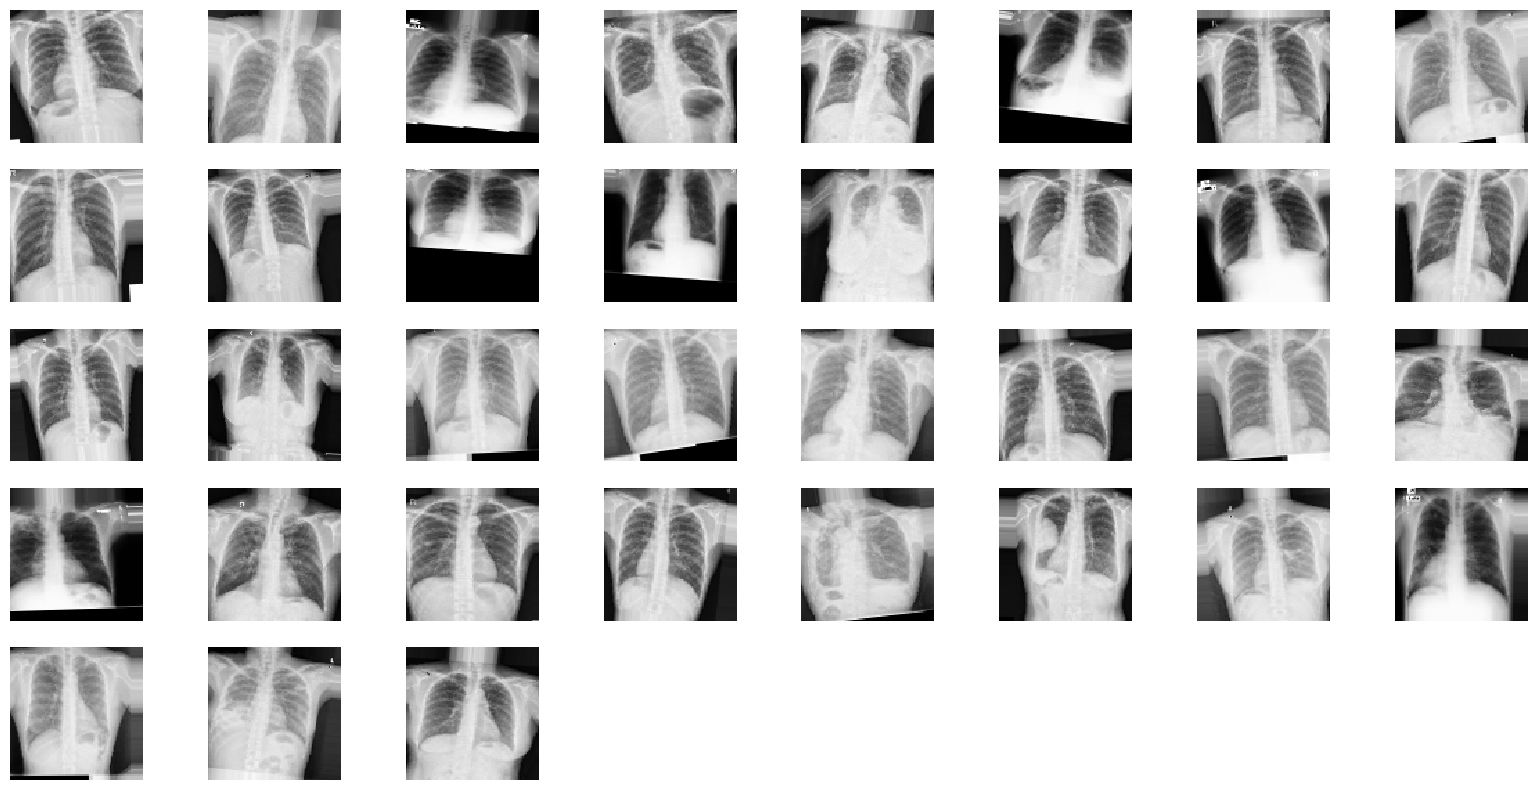

In [815]:
plots(imgs, titles=None) # titles=labels will display the image labels

### Set Up the Generators

In [816]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps =int( np.ceil(num_train_samples / train_batch_size))
val_steps = int(np.ceil(num_val_samples / val_batch_size))

In [817]:

datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical',
                                        shuffle=False)

Found 2151 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


###  the Model Architecture

In [342]:
pip show keras

^C
Note: you may need to restart the kernel to use updated packages.


In [289]:
pip install --upgrade --force-reinstall keras


^C
Note: you may need to restart the kernel to use updated packages.


In [818]:

kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))
model.summary()


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_200 (Conv2D)             │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_201 (Conv2D)             │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_202 (Conv2D)             │ (None, 90, 90, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_102 (Dropout)           │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_203 (Conv2D)             │ (None, 43, 43, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_204 (Conv2D)             │ (None, 41, 41, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_205 (Conv2D)             │ (None, 39, 39, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_103 (Dropout)           │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_206 (Conv2D)             │ (None, 17, 17, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_207 (Conv2D)             │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_208 (Conv2D)             │ (None, 13, 13, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_104 (Dropout)           │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_105 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,661,186 (6.34 MB)

 Trainable params: 1,661,186 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Model

In [819]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001)

In [820]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [402]:

filepath = "model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_gen, steps_per_epoch=train_steps, 
                            validation_data=val_gen,
                            validation_steps=val_steps,
                            epochs=100, verbose=1,
                           callbacks=callbacks_list,
                           #steps_per_epoch = len(train_gen) // batch_size,
                           #validation_steps = len(val_gen) //batch_size

                   )

Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.8501 - loss: 0.3250 - val_accuracy: 0.8083 - val_loss: 0.4938 - learning_rate: 1.0000e-04
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.8421 - loss: 0.3473 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8282 - loss: 0.3552 - val_accuracy: 0.7833 - val_loss: 0.5035 - learning_rate: 1.0000e-04
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8176 - loss: 0.3955 - val_accuracy: 0.7917 - val_loss: 0.5252 - learning_rate: 1.0000e-04
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8640 - loss: 0.3174 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━

### Evaluate the model using the val set

In [821]:
model.metrics_names

['loss', 'compile_metrics']

In [822]:

model.load_weights('model.keras')

val_loss, val_acc = \
model.evaluate(test_gen, 
                        steps=val_steps)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 302ms/step - accuracy: 0.8324 - loss: 0.4512
val_loss: 0.4893883764743805
val_acc: 0.7833333611488342


### Create a Confusion Matrix

In [828]:

test_labels = test_gen.classes

In [829]:
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [728]:
test_gen.class_indices

{'Normal': 0, 'Tuberculosis': 1}

In [830]:
predictions = model.predict(test_gen, steps=val_steps, verbose=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 274ms/step


In [831]:
predictions.shape

(120, 2)

In [832]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [833]:
test_labels.shape

(120,)

In [834]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [835]:
test_gen.class_indices

{'Normal': 0, 'Tuberculosis': 1}

Confusion matrix, without normalization
[[50 11]
 [15 44]]


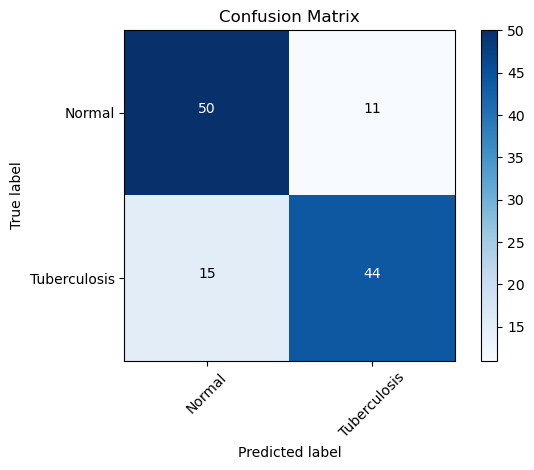

In [836]:
# Define the labels of the class indices 
cm_plot_labels = ['Normal', 'Tuberculosis']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Create a Classification Report

In [837]:

test_filenames = test_gen.filenames

y_true = test_gen.classes

# Get the predicted labels
y_pred = predictions.argmax(axis=1)

In [838]:
from sklearn.metrics import classification_report

#  classification report

report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)


              precision    recall  f1-score   support

      Normal       0.77      0.82      0.79        61
Tuberculosis       0.80      0.75      0.77        59

    accuracy                           0.78       120
   macro avg       0.78      0.78      0.78       120
weighted avg       0.78      0.78      0.78       120



##SVM MODEL

In [841]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#  SVM classifier
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale')

# Train 
svm_classifier.fit(X_train_scaled, y_train)

# Predictions
y_pred_train = svm_classifier.predict(X_train_scaled)
y_pred_test = svm_classifier.predict(X_test_scaled)

# Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

# Classification report
print("\nClassification Report for Testing Data:")
print(classification_report(y_test, y_pred_test))


Training Accuracy: 0.5909090909090909
Testing Accuracy: 0.6071428571428571

Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       0.67      0.78      0.72        18
           1       0.43      0.30      0.35        10

    accuracy                           0.61        28
   macro avg       0.55      0.54      0.54        28
weighted avg       0.58      0.61      0.59        28



In [840]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

image_dir = r'C:\Users\Admin\Downloads\archive\Montgomery\MontgomerySet\CXR_png'

X = []
y = []

for filename in os.listdir(image_dir):
    if filename.endswith('.png'):
        # Load image
        image_path = os.path.join(image_dir, filename)
        image = Image.open(image_path)
        
        mean_pixel_value = np.mean(np.array(image))
        
        X.append(mean_pixel_value)
        
        label = int(filename[-5])  
        y.append(label)

# Convert lists to numpy arrays
X = np.array(X).reshape(-1, 1) 
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the Random Forest classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train_scaled, y_train)

# Predictions
y_pred_train = random_forest.predict(X_train_scaled)
y_pred_test = random_forest.predict(X_test_scaled)

# Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

# Classification report
print("\nClassification Report for Testing Data:")
print(classification_report(y_test, y_pred_test))


Training Accuracy: 1.0
Testing Accuracy: 0.4642857142857143

Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       0.62      0.44      0.52        18
           1       0.33      0.50      0.40        10

    accuracy                           0.46        28
   macro avg       0.47      0.47      0.46        28
weighted avg       0.51      0.46      0.47        28



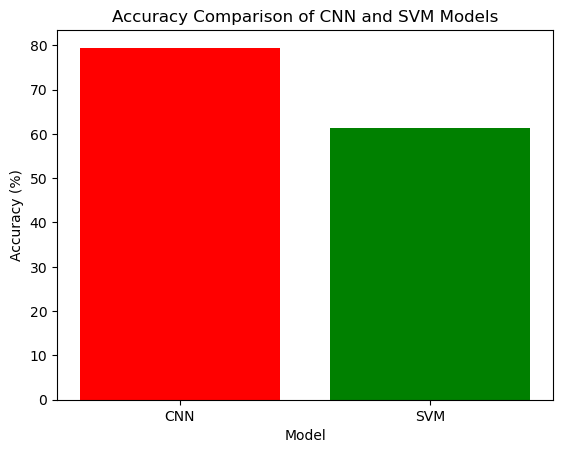

In [604]:
import matplotlib.pyplot as plt
x = []
y = []

x.append("CNN")
y.append(79.44)

x.append("SVM")
y.append(61.249)

plt.bar(x, y, color=['red', 'green'])

plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Comparison of CNN and SVM Models")
plt.show()

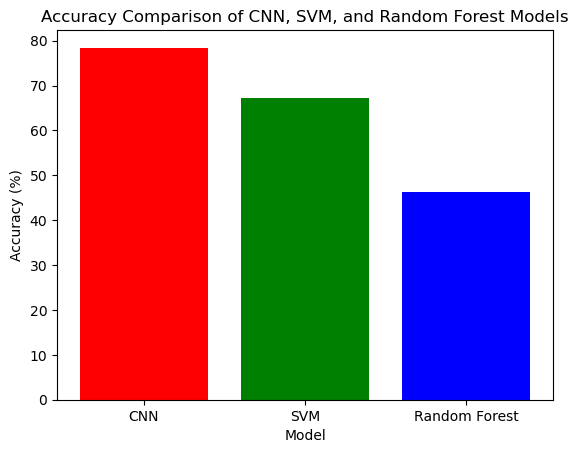

In [607]:
import matplotlib.pyplot as plt

models = ['CNN', 'SVM', 'Random Forest']
accuracies = [78.44, 67.00, 46.288]

plt.bar(models, accuracies, color=['red', 'green', 'blue'])

plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Comparison of CNN, SVM, and Random Forest Models")

plt.show()

In [842]:
X.shape

(138, 1)

In [843]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten
from keras.utils import to_categorical

# Directory containing X-ray images
image_dir = r'C:\Users\Admin\Downloads\archive\Montgomery\MontgomerySet\CXR_png'

# List to store image data (X) and labels (y)
X = []
y = []

# Loop through all image files in the directory
for filename in os.listdir(image_dir):
    if filename.endswith('.png'):
        # Load image
        image_path = os.path.join(image_dir, filename)
        image = Image.open(image_path)
        
        image = image.resize((64, 64))  # Resize image to 64x64 pixels
        
        image_array = np.array(image)
        
        X.append(image_array)
        
        label = int(filename[-5])  
        y.append(label)

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

X = X / 255.0

# Convert labels to one-hot encoded vectors
y = to_categorical(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(LSTM(units=128, input_shape=(X.shape[1:]), return_sequences=True))
model.add(Flatten())
model.add(Dense(units=2, activation='softmax'))  # Assuming binary classification (normal vs. pneumonia)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate 
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 582ms/step - accuracy: 0.4464 - loss: 0.9084 - val_accuracy: 0.6429 - val_loss: 0.8935
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.5213 - loss: 1.0059 - val_accuracy: 0.4286 - val_loss: 0.7747
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5463 - loss: 0.6744 - val_accuracy: 0.5714 - val_loss: 0.6915
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6701 - loss: 0.5956 - val_accuracy: 0.6071 - val_loss: 0.6835
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6035 - loss: 0.6637 - val_accuracy: 0.6071 - val_loss: 0.6923
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7029 - loss: 0.5854 - val_accuracy: 0.5357 - val_loss: 0.7474
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7237 - loss: 0.5308 - val_accuracy: 0.5357 - val_loss: 0.7107
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7773 - loss: 0.5307 - val_accuracy: 0.5357 - val_loss: 0.729

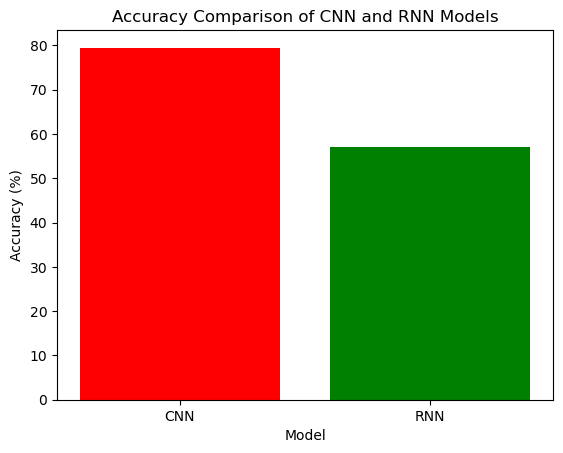

In [2]:
import matplotlib.pyplot as plt
x = []
y = []

x.append("CNN")
y.append(79.49)

x.append("RNN")
y.append(57.00)

plt.bar(x, y, color=['red', 'green'])

plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Comparison of CNN and RNN Models")
plt.show()